In [1]:
import numpy as np # using version 1.22.4 as the newer version unsuitable for stable baselines 3
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math

In [2]:
from stable_baselines3 import PPO

In [3]:
## Rastrigin Function and its directional derivatives

def ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    res = np.linalg.norm( A@cord - B )
    res = 0.5 * (res ** 2)

    angle = np.array(2 * math.pi * cord)
    tri = C@np.cos(angle)

    res = res - tri + n
  
    return res[0][0]


def grad_ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    Anew = A.copy()
    res = Anew@cord - B

    res = np.append(res, [[2 * math.pi]])
  
    tri = np.sin(2 * math.pi * cord)
  
    a = C@tri
  
    val = np.full((n, 1), a[0][0])
  
    Anew = np.hstack((Anew, val))
 
    res = Anew@res
  
    return res

In [5]:
# Parameters

n = 3  # Number of dimensions of the function

# Observation space limits
HIGH = 10000
LOW = -10000

# Limits of the area in which initialization will take place
INIT_HIGH = 30 
INIT_LOW = -30

PREV = 3 # number of previous iterates to consider as states

MAX_STEP = 100 # maximum number of steps per episode, trancation if still not converged

COUNTER = 1000 # maximum number of episodes for a set of parameters

# Initialization of the A,B,C parameters of the Rastrigan-like function
A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)

TOLERANCE = 1e-5 # if the change is lower than this then the episode will terminate

BOUNDARY_PENALTY = -10000 # reward if point goes outside the boundary
MAX_GRADIENT = 10000

In [6]:
# Custom environment

class L2O_RL(gym.Env):
    
    def __init__(self, n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT):
        super(L2O_RL, self).__init__()
        
        # Variables
        self.n = n
        self.dim = 2*n*PREV
        
        self.high = HIGH
        self.low = LOW
        self.init_high = INIT_HIGH
        self.init_low = INIT_LOW
        
        self.step_no = 0
        self.max_step = MAX_STEP
        self.counter = COUNTER
        self.max_counter = COUNTER
        
        self.A = A
        self.B = B
        self.C = C
        
        self.tolerance = TOLERANCE
        self.boundary_penalty = BOUNDARY_PENALTY
        self.max_gradient = MAX_GRADIENT
    
        # Spaces
        self.observation_space = spaces.Box(low = LOW, high = HIGH, shape=(self.dim,), dtype = np.float32)
        self.action_space = spaces.Box(low = LOW, high = HIGH, shape=(self.n,), dtype = np.float32)
        
        # State
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Random Initialization of the starting point
        self.dq = deque(np.zeros(self.dim, dtype = np.float32))
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # Gradient at that point
        
        for i in range(2*self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        self.dq.extendleft(np.flip(self.cord))
        
        self.observation = np.array(self.dq, dtype = np.float32)
        
    def step(self, action):
        self.cord = self.cord + action
        
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # gradient at the new coordinates
        
        terminated = False
        truncated = False
        info = {}
        
        boundary_flag = False
        
        # check if the coordinates are out of the limits
        for i in range(self.n):
            if self.cord[i] > self.high:
                boundary_flag = True
                self.cord[i] = np.float32(self.high)
                
            elif self.cord[i] < self.low:
                boundary_flag = True
                self.cord[i] = np.float32(self.low)
       
        # check if the gradients are out of the limits
        for i in range(self.n):
            self.grad[i] = min(self.grad[i], self.max_gradient)
            self.grad[i] = max(self.grad[i], (-1*self.max_gradient))
        
        # calculate observation
        for i in range(2*self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        self.dq.extendleft(np.flip(self.cord))
        self.observation = np.array(self.dq, dtype = np.float32)
        
        # truncate if more than max number of steps
        self.step_no = self.step_no + 1
        if self.step_no >= self.max_step:
            truncated = True
        
        # calculate reward
        if(boundary_flag == True):
            terminated = True
            reward = self.boundary_penalty
        else:    
            reward = -1*ras(self.cord, self.A, self.B, self.C)
        
        # terminate if converged
        if not terminated:
            for i in range(self.n):
                if np.abs(self.dq[i] - self.dq[i+2*self.n]) <= self.tolerance:
                    terminated = True
                    
        return self.observation, reward, terminated, truncated, info
    
    def reset(self, seed = None, options = None):
        super().reset(seed=seed, options=options)
        info = {}
        
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Initialization of the starting point
        self.dq = deque(np.zeros(self.dim, dtype = np.float32))
        self.grad = grad_ras(self.cord, self.A, self.B, self.C)
        
        for i in range(2*self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        self.dq.extendleft(np.flip(self.cord))
        
        self.observation = np.array(self.dq, dtype = np.float32)
        
        self.step_no = 0
        
        if self.counter == 0:
            self.counter = self.max_counter
            self.A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
            self.B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
            self.C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)
            
        else:
            self.counter = self.counter-1
            
        
        return self.observation, info

In [24]:
from stable_baselines3.common.env_checker import check_env

env = L2O_RL( n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT)
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [8]:
import os

In [25]:
logdir = "logs"

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log= logdir)
model.learn(1000000, tb_log_name = "PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_5
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -2.83e+05 |
| time/              |           |
|    fps             | 826       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.46e+05     |
| time/                   |               |
|    fps                  | 557           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00034317013 |
|    clip_fraction        | 0             |
|    c

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.25e+05    |
| time/                   |              |
|    fps                  | 658          |
|    iterations           | 11           |
|    time_elapsed         | 34           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 6.611459e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -0.000147    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.46e+09     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.000231    |
|    std                  | 1            |
|    value_loss           | 2.86e+09     |
------------------------------------------
-------------------------------------------
| rollout/

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.22e+05    |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 20           |
|    time_elapsed         | 54           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 8.536095e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -5.88e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.31e+08     |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.000194    |
|    std                  | 1            |
|    value_loss           | 1.63e+09     |
------------------------------------------
--------------------------------------------
| rollout

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.41e+05     |
| time/                   |               |
|    fps                  | 785           |
|    iterations           | 29            |
|    time_elapsed         | 75            |
|    total_timesteps      | 59392         |
| train/                  |               |
|    approx_kl            | 0.00028011377 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | -2.72e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.18e+08      |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000958     |
|    std                  | 0.998         |
|    value_loss           | 7.56e+08      |
-------------------------------------------
--------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 99.5         |
|    ep_rew_mean          | -6.05e+04    |
| time/                   |              |
|    fps                  | 803          |
|    iterations           | 38           |
|    time_elapsed         | 96           |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0017572244 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -1.19e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 7.89e+07     |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.999        |
|    value_loss           | 1.16e+08     |
------------------------------------------
----------------------------------------
| rollout/   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.72e+04  |
| time/                   |            |
|    fps                  | 803        |
|    iterations           | 47         |
|    time_elapsed         | 119        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.00739633 |
|    clip_fraction        | 0.0541     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.23      |
|    explained_variance   | -1.91e-06  |
|    learning_rate        | 0.0003     |
|    loss                 | 1.42e+07   |
|    n_updates            | 460        |
|    policy_gradient_loss | -0.012     |
|    std                  | 0.994      |
|    value_loss           | 7.17e+06   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 99.7         |
|    ep_rew_mean          | -2.37e+04    |
| time/                   |              |
|    fps                  | 798          |
|    iterations           | 56           |
|    time_elapsed         | 143          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0034875232 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.49e+07     |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00718     |
|    std                  | 0.98         |
|    value_loss           | 2.87e+07     |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.53e+04   |
| time/                   |             |
|    fps                  | 791         |
|    iterations           | 65          |
|    time_elapsed         | 168         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.005488603 |
|    clip_fraction        | 0.0244      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.19       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.38e+05    |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0112     |
|    std                  | 0.974       |
|    value_loss           | 4.91e+06    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.45e+04   |
| time/                   |             |
|    fps                  | 780         |
|    iterations           | 74          |
|    time_elapsed         | 194         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.005054562 |
|    clip_fraction        | 0.0282      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.12       |
|    explained_variance   | -0.00239    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.02e+06    |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.96        |
|    value_loss           | 1.19e+07    |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.1e+04    |
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 83          |
|    time_elapsed         | 221         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.006761194 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.04       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.41e+06    |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.928       |
|    value_loss           | 2.6e+06     |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.04e+04    |
| time/                   |              |
|    fps                  | 765          |
|    iterations           | 92           |
|    time_elapsed         | 245          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0061470685 |
|    clip_fraction        | 0.0559       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.01        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.2e+05      |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00955     |
|    std                  | 0.919        |
|    value_loss           | 4.05e+06     |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -8.73e+03   |
| time/                   |             |
|    fps                  | 761         |
|    iterations           | 101         |
|    time_elapsed         | 271         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.010426203 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.89       |
|    explained_variance   | -1.93e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.51e+05    |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.884       |
|    value_loss           | 1.55e+06    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.25e+03   |
| time/                   |             |
|    fps                  | 756         |
|    iterations           | 110         |
|    time_elapsed         | 297         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.016628271 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | -3.1e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 9.83e+03    |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.0211     |
|    std                  | 0.902       |
|    value_loss           | 2.96e+05    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -2.65e+03  |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 119        |
|    time_elapsed         | 321        |
|    total_timesteps      | 243712     |
| train/                  |            |
|    approx_kl            | 0.03654532 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.87      |
|    explained_variance   | -3.58e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 9.76e+03   |
|    n_updates            | 1180       |
|    policy_gradient_loss | 0.000548   |
|    std                  | 0.878      |
|    value_loss           | 5.95e+04   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.46e+03   |
| time/                   |             |
|    fps                  | 755         |
|    iterations           | 128         |
|    time_elapsed         | 346         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.024911026 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.82       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.5e+04     |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00649    |
|    std                  | 0.865       |
|    value_loss           | 1.15e+05    |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.17e+03   |
| time/                   |             |
|    fps                  | 751         |
|    iterations           | 137         |
|    time_elapsed         | 373         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.014447446 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.81       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.54e+03    |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.0122     |
|    std                  | 0.863       |
|    value_loss           | 7.83e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.5        |
|    ep_rew_mean          | -1.99e+03   |
| time/                   |             |
|    fps                  | 754         |
|    iterations           | 146         |
|    time_elapsed         | 396         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.007524036 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.8        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.73e+03    |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.0168     |
|    std                  | 0.859       |
|    value_loss           | 2.31e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.69e+03    |
| time/                   |              |
|    fps                  | 755          |
|    iterations           | 155          |
|    time_elapsed         | 419          |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0050896155 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.77        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.53e+05     |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.0118      |
|    std                  | 0.851        |
|    value_loss           | 4.89e+05     |
------------------------------------------
-----------------------------------------
| rollout/  

In [ ]:
model.save("model-v4")

In [13]:
iteration = 100
lr = 0.003

## Evaluataion
val_gd = []
val_rl = []

#env.reset()

A, B, C = env.A, env.B, env.C #A,B,C values
xyz_int = np.random.uniform(env.init_low, env.init_high, env.n)
xyz_rl = xyz_int
xyz_gd = xyz_int

grad = grad_ras(xyz_int, A, B, C)

test_dq = deque(np.zeros(env.dim, dtype = np.float32))
for i in range(2*env.n):
    test_dq.pop()
test_dq.extendleft(np.flip(grad))
test_dq.extendleft(np.flip(xyz_int))
        
observation = np.array(test_dq, dtype = np.float32)


for i in range(100):
    # gradient descent
    xyz_gd = xyz_gd - lr*grad_ras(xyz_gd, A, B, C)
    val_gd.append(ras(xyz_gd, A, B, C))
    
    # reinforcement learning
    xyz_rl = xyz_rl + model.predict(observation)[0]
    
    grad = grad_ras(xyz_rl, A, B, C)
    for i in range(2*env.n):
        test_dq.pop()
    test_dq.extendleft(np.flip(grad))
    test_dq.extendleft(np.flip(xyz_rl))
    
    val_rl.append(ras(xyz_rl, A, B, C))
    

In [14]:
import matplotlib.pyplot as plt

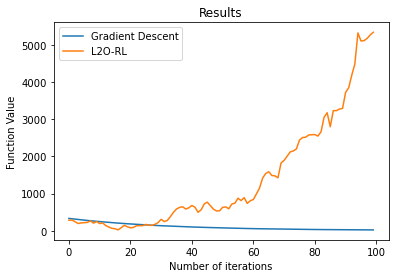

In [23]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()